# COMP90051 Project 2

# Overview
Through the 2000s Yahoo! Research led the way in applying MABs to problems in online advertising, information retrieval, and media recommendation. One of their many applications was to Yahoo! News, in deciding
what news items to recommend to users based on article content, user profile, and the historical engagement
of the user with articles. Given decision making in this setting is sequential--what do we show next--and
feedback is only available for articles shown, Yahoo! researchers observed a perfect formulation for MABs like
those (-Greedy and UCB). Going further, however, they realised that incorporating
some element of user-article state requires contextual bandits: articles are arms; context per round incorporates information about both user and article (arm); and {0; 1}-valued rewards represent clicks. 

Therefore the per round cumulative reward represents click-through-rate (CTR) which is exactly what services like Yahoo!
News want to maximise to drive user engagement and advertising revenue.



# Introduction
Collaborative filtering: works by recommending things that similar customers liked. 
However, it suffers from the cold-start problem, which is when there are new products that no one has used or liked.


Content-based filtering: matches up content or products based on their attributes to a customer’s preferences.


Multi-armed bandit algorithms, however, can offer a solution because:

1.They can recommend products with the highest expected value while still exploring other products.

2.They do not suffer from the cold-start problem and therefore don’t require customer preferences or information about products.

Exploitation : MABs optimises short-term rewards by acting greedily based on current knowledge

Exploration :  MABs optimise for long-term cumulative reward.

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from IPython.display import Image

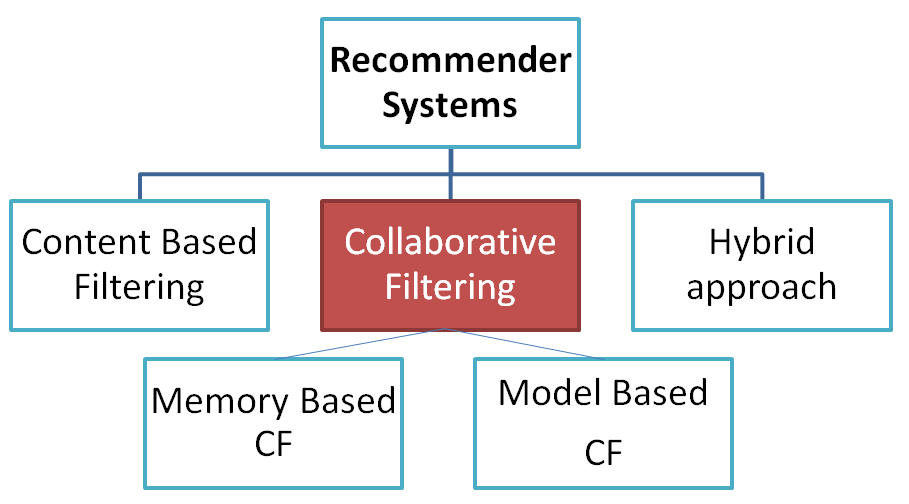

In [2]:
Image(filename="classic_recomend.PNG",width=600,height=400)

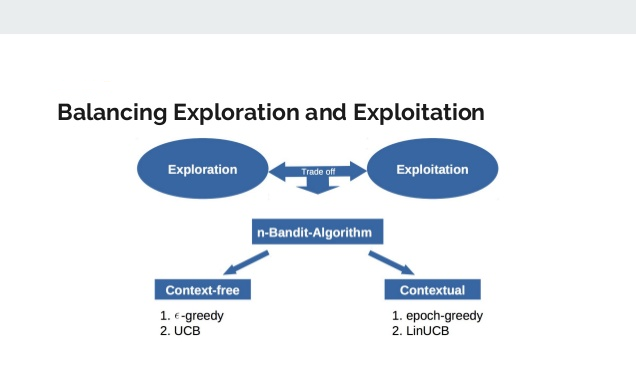

In [3]:
Image(filename="overview_1.PNG",width=600,height=400)

In [4]:
# Load event log from a bandit run
data = np.genfromtxt('dataset.txt')
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2::]


## 1. Implementing ε-Greedy and UCB

In [5]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

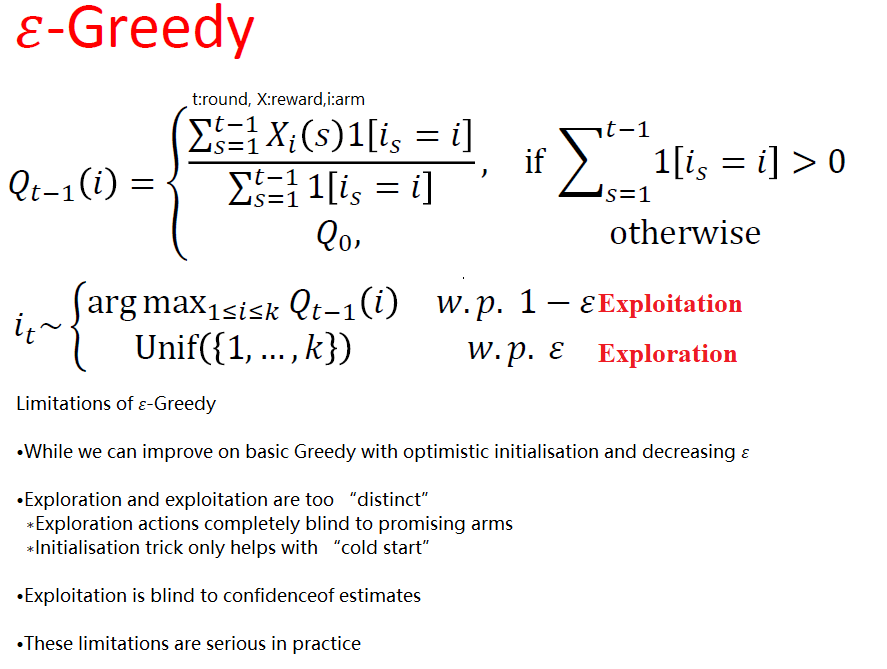

In [34]:
Image(filename="epsilon_1.PNG",width=600,height=400)

In [7]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms=narms
        self.epsilon=epsilon
        self.Q = np.full(self.narms,Q0) #list of Q values for each arm
        self.arms_counts = np.zeros(narms) #list of rounds that each arm has plyaed
        self.arms_rewards = np.zeros(narms) #list of reward for each arm
        
        
        
    def play(self, tround, context=None):
        
        
        #Check whether invalid tround value
        if (tround <= sum(self.arms_counts)) and (tround > 1):
            return None
        if tround == 0 or (tround > sum(self.arms_counts)+1):  
            return None
        
        # choose a bandit
        if np.random.random() > self.epsilon: #exploitation
             
            max_arm = [i for i in range(len(self.Q)) if self.Q[i] == max(self.Q)] #choose the arms with max Qvalues 
            chosen_arm=np.random.choice(max_arm)+1 #randomly choose a arm from max_arm list
            
        else:
            chosen_arm= np.random.randint(self.narms)+1 #exploration
            
        
        return chosen_arm

        
    def update(self, arm, reward, context=None):
      
        # Check if the arm_id is valid
        if (arm > self.narms) or (arm < 1): 
            return None

        
        #update the rounds and rewards of the input arm
        self.arms_counts[arm-1]+=1.0 
        self.arms_rewards[arm-1]+=reward
        if self.arms_counts[arm-1]>0:
            self.Q[arm-1] = float(self.arms_rewards[arm-1]) / float(self.arms_counts[arm-1]) 

        
        


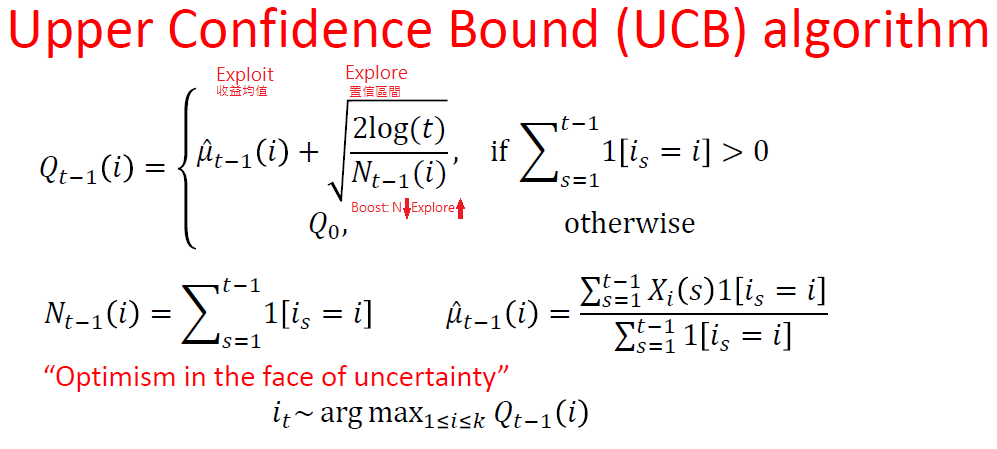

In [8]:
Image(filename="UPC_1.PNG",width=600,height=400)

In [9]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms=narms
        self.rho=rho
        self.Q0 = Q0
        
        self.Q = np.full(self.narms,Q0) #list of Q values for each arm
        self.arms_counts = np.zeros(narms) #list of rounds that each arm has plyaed
        self.rewards=np.zeros(narms) #list of reward observed for each arm
    
    def play(self, tround, context=None):
        
        #Check whether invalid tround value
        if (tround <= sum(self.arms_counts)) and (tround > 1):
            return None
        if tround == 0 or (tround > sum(self.arms_counts)+1): 
            return None
        

        #Compute Q value for each of arm 
        for arm in range(self.narms):           
            if  self.arms_counts[arm]>0:
                bonus=np.sqrt(self.rho * np.log(tround) / float(self.arms_counts[arm]))
                #Estimate Q value of each arm who has been pulled  as average reward observe
                self.Q[arm] = (self.rewards[arm]/float(self.arms_counts[arm]))+bonus  #average_reward+bomus

        # choose a bandit
        max_arm = [i for i in range(len(self.Q)) if self.Q[i] == max(self.Q)] #choose the arms with max Qvalues
        chosen_arm=np.random.choice(max_arm)+1 #randomly choose a arm from max_arm list
        return chosen_arm
    
        
    def update(self, arm, reward, context=None):
        
        # Check if the arm_id is valid
        if (arm > self.narms) or (arm < 1): 
            return None
            
        #update the rounds and reward of the input arm
        self.arms_counts[arm-1]+=1
        self.rewards[arm-1]+=reward

## 2. The Basic Thompson Bandit

The Thompson Bandit is now regarded as a leading MAB technique, that uses a Bayesian model of rewards. The simplest Thompson sampler models rewards in {0;1}as Bernoulli draws with different parameters per arm each starting with a common Beta prior.

Here,the Beta-Bernoulli Thompson MAB as described in Algorithm 1 "Thompson Sampling for Bernoulli bandits" from the paper is implemented. (http://proceedings.mlr.press/v23/agrawal12/agrawal12.pdf)

While in the paper, Algorithm 1 only considers a uniform Beta(1; 1) prior, we implementd a more flexible Beta(α0; β0) prior for any given α0; β0 > 0. A point that may be missed is that while each arm begins with the same prior, each arm updates its own posterior.

PS:BetaThompson should sub-class abstract MAB base class with components similar to above:

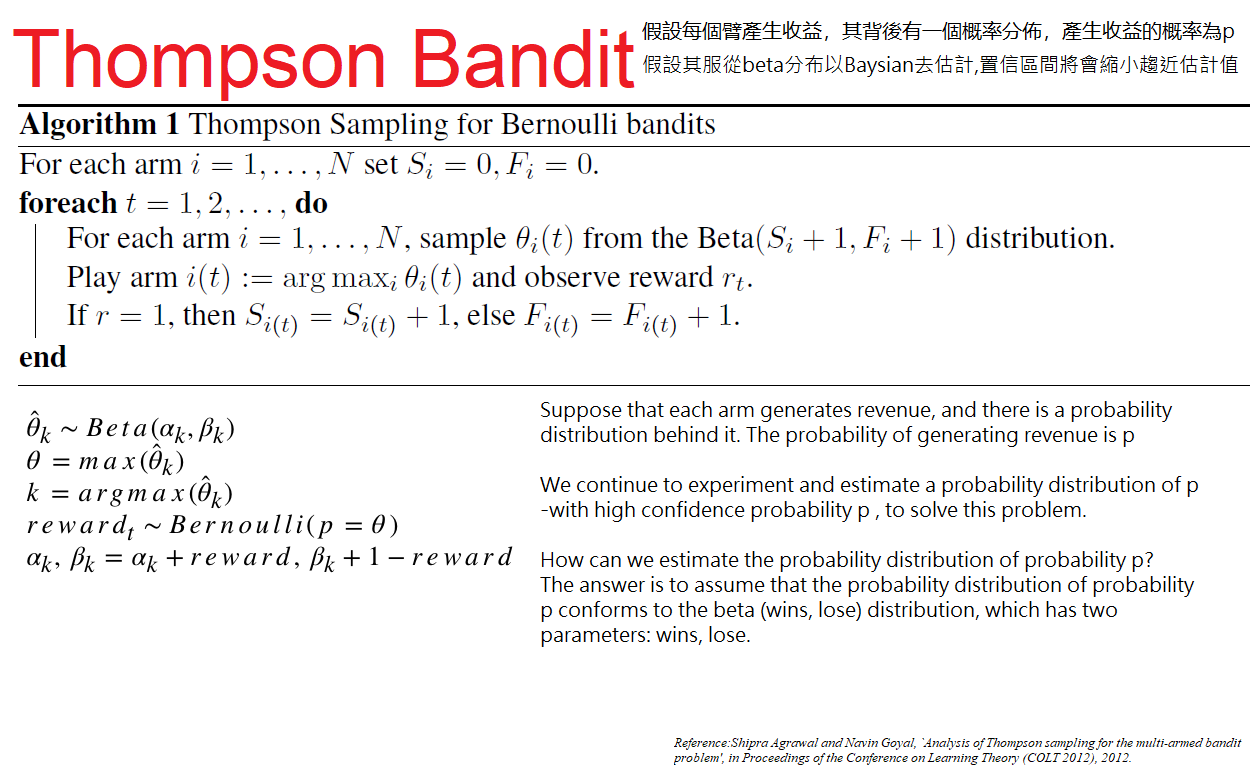

In [10]:
Image(filename="Thompson_1.PNG",width=800,height=500)

In [11]:

class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        self.narms=narms
        self.alpha0 =alpha0
        self.beta0 = beta0        
        self.trials = np.zeros(narms) #a list of num_trial for each arm
        self.win = np.zeros(narms) #a list of num_win for each arm
        self.fails = np.zeros(narms) #a list of num_win for each arm
        
        
    def play(self, tround, context=None):
        
        #Check whether invalid tround value
        if (tround <= sum(self.trials)) and (tround > 1):
            return None        
        if tround == 0 or (tround > sum(self.trials)+1):
            return None
        
        # Beta is the prior for Bernoulli rewards and Sample theta(Bernouli mean:u) from Beta(S+1,F+1)for each bandit
        theta_samples = [np.random.beta(a=self.alpha0+self.win[i], b=self.beta0+self.fails[i]) for i in range(self.narms)]
            
        # choose a bandit
        max_arm = [np.argmax(theta_samples)]#choose the arms with max Qvalues
        chosen_arm=np.random.choice(max_arm)+1 #randomly choose a arm from max_arm list
        
        return chosen_arm
        
    def update(self, arm, reward, context=None):# Update trials and wins (defines the posterior)
        
        # Check if the arm_id is valid
        if (arm > self.narms) or (arm < 1): 
            return None
        
        
        if reward==1:
            
            self.win[arm-1] += 1 # if win then update num_win for the input arm
        else:
            self.fails[arm-1]+=1 # if fail then update num_fails for the input arm
            
        self.trials[arm-1] += 1 #update num_trials for the input arm
        

## 3. Off-Policy Evaluation

A major practical challenge for industry deployments of MAB learners has been the requirement to let the
learner loose on real data. Inevitably bandits begin with little knowledge about arm reward structure, and so
a bandit must necessarily super poor rewards in beginning rounds. For a company trying out and evaluating
dozens of bandits in their data science groups, this is potentially very expensive.

A breakthrough was made when it was realised that MABs can be evaluated online-or-off-line policy. 

The idea being that you collect just once a dataset of uniformly-random arm pulls and resulting rewards. 
Then when evaluating any possible future bandit learner of interest on that one historical data, there is no need to run bandits online in order to evaluate them!


Here, the algorythm 3 from this paper, "A Contextual-Bandit Approach to Personalized News Article Recommendation",https://arxiv.org/pdf/1003.0146.pdf  is implemented.

PS: arms corresponds to the arms played by a uniformly-random policy recorded in a dataset of M events. While rewards corresponds to the resulting observed M rewards.

Solve:
1. dynamically changing
2. the scale of learning and computation

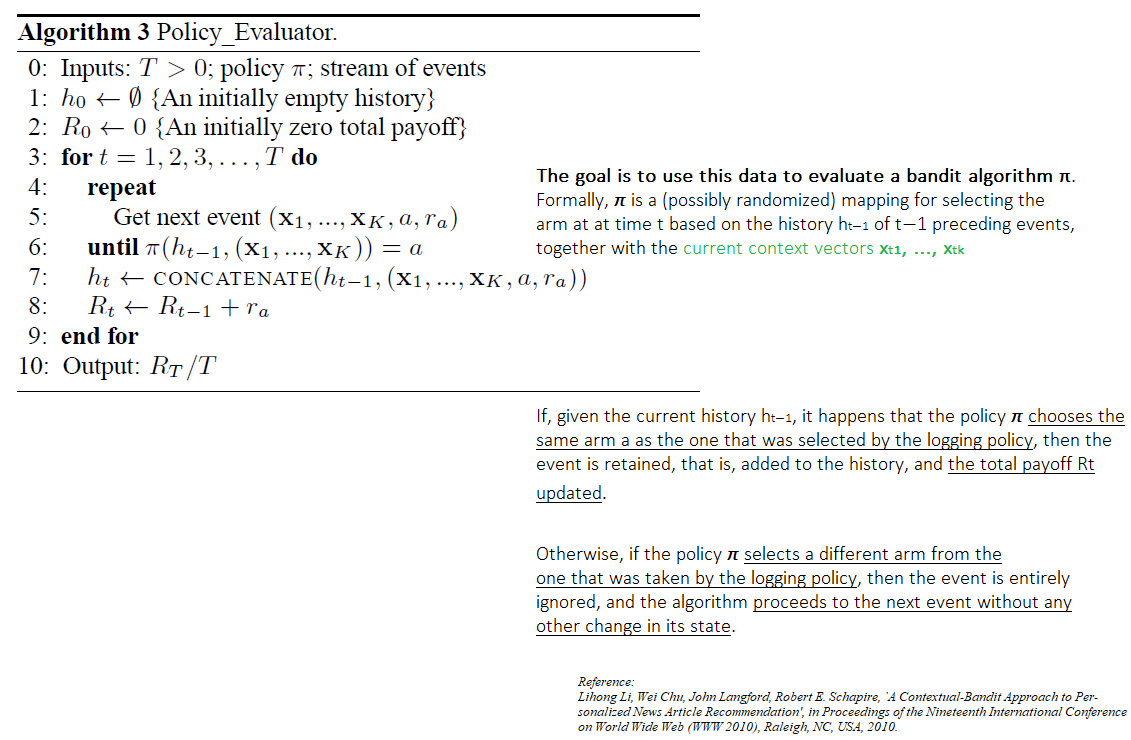

In [12]:
Image(filename="off_line_1.PNG",width=800,height=500)

In [13]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    match_round = 1 #initiate number of match_event
    match_reward = list() #initial list to total payoff
    All_logged=len(data) #number of events

        
    for i in range(All_logged):
        
        #Invalid nrounds value
        if nrounds is not None and match_round > nrounds: 
            break
        
        #nrounds is not invalid value
        else:
            #playing arm is  based on previous events and current context vector (h.t-1,(xt1,xt2,...xtk))
            arm=mab.play(match_round ,contexts[i]) 
            #check whether the playing arm matches event arm ; if not, ignoring this event
            if  arm==arms[i]: 
                mab.update(arm, rewards[i], contexts[i]) #update this current state
                match_reward.append(rewards[i]) #update total payoff
                match_round += 1


    return match_reward



In [31]:
mab=EpsGreedy(10, 0.1)

results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.15375


In [15]:
len(results_EpsGreedy)

800

In [16]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1725


In [17]:
len(results_UCB)

800

In [18]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.19125


In [19]:
len(results_BetaThompson)

800

## 4. Contextual Bandits - LinUCB
The contextual bandits, in which each arm may have a feature vector representing its state/context (and potentially
factoring in the context of the user also). So that if each of the K arms have d features, each row of contexts
will have these feature vectors  attened as the d features of arm 1 followed by the d features of arm 2, all the
way up to arm K so that we have d * K features (a multiple of K).


Data set:
1. 10,000 lines (i.e., rows) corresponding to distinct site visits by users-events in the language of this part;
2. Each row comprises 102 space-delimited columns of integers:
{ Column 1: arms,The arm played by a uniformly-random policy out of 10 arms (news articles);
{ Column 2: rewards, The reward received from the arm played, 1 if the user clicked 0 otherwise;
{ Columns 3-102: contexts, The 100-dim attened context: 10 features per arm (incorporating the content of
the article and its match with the visiting user), first the features for arm 1, then arm 2, etc. up to
arm 10.

UCB + ridge regression

contextual & UCB

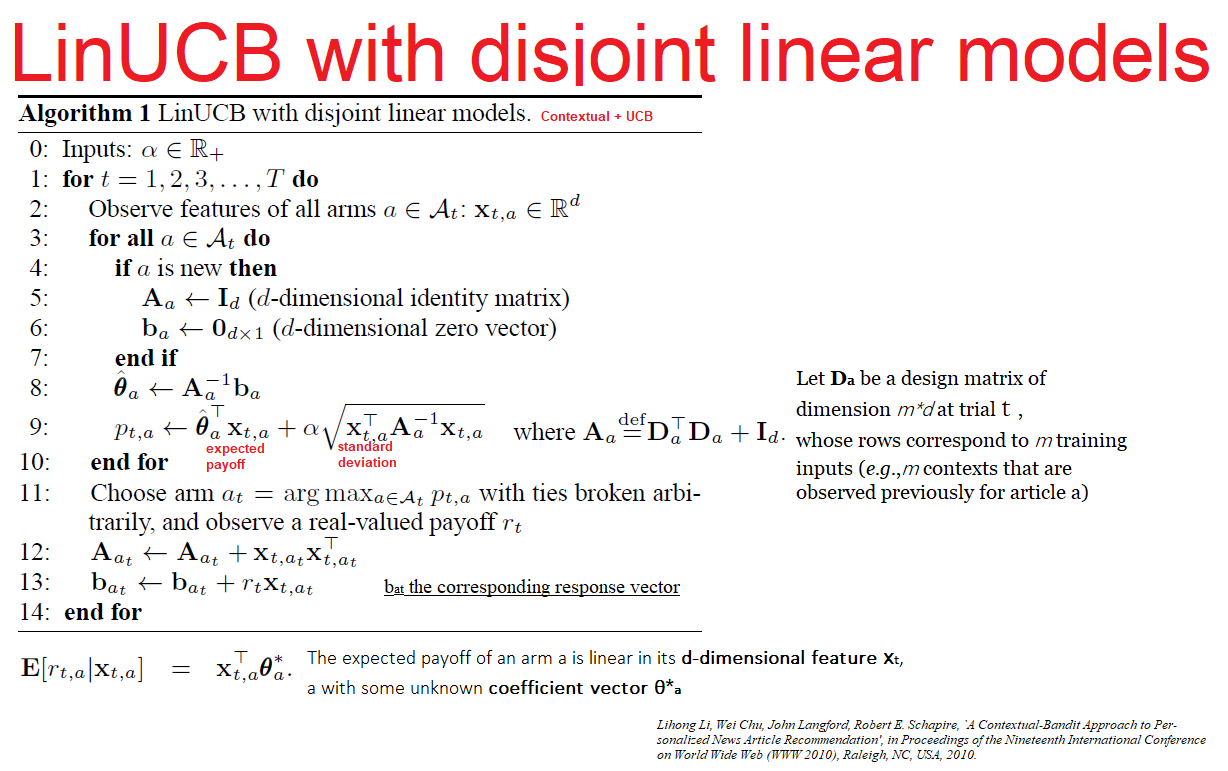

In [20]:
Image(filename="LinUCB.PNG",width=800,height=500)

In [33]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms=narms
        self.ndims=ndims
        self.alpha = alpha
        self.nrounds=0
        self.A = [np.identity(self.ndims) for arm in range(narms)] #initial identity matrix A for each arm(disjoint)
        self.b = [np.zeros((self.ndims, 1)) for arm in range(narms)] #initial response vector b for each arm(disjoint)

    
    def play(self, tround, context):
        
        
        if (tround <= self.nrounds) and (tround > 1):
            return None
        if tround == 0 or (tround > self.nrounds+1): #Invalid tround value 
            return None
        
        

        p_t = [0]*self.narms
        for i in range(self.narms):
            
            #get feature of arm i into shape (10,1)
            x_feature=context[i*self.ndims:(i+1)*self.ndims].reshape(-1,1)  
            x_feature_T = np.transpose(x_feature)
            
            #compute theta for the arm i
            theta_arm = np.dot(inv(self.A[i]), self.b[i])
            theta_arm_T=np.transpose(theta_arm)
        
            
            #compute the expected payoff of arm i (by ridge-regression solution)
            #the first term implies expected payoff + the second term implies standard deviation. 
            p_t[i] = np.dot(theta_arm_T, x_feature) + self.alpha * np.sqrt(np.dot(np.dot(x_feature_T, inv(self.A[i])), x_feature))
            
        max_arm = [i for i in range(self.narms) if p_t[i] == max(p_t)]#choose the arms with max payoff  
        chosen_arm = np.random.choice(max_arm)+1 #randomly choose a arm from max_arm list
        
        return chosen_arm
            
    def update(self, arm, reward, context):
        # Check if the arm_id is valid
        if (arm > self.narms) or (arm < 1): 
            return None
        
        #update input arm's feature        
        x_feature = context[(arm-1)*self.ndims:arm*self.ndims].reshape(-1,1)  
        x_feature_T = np.transpose(x_feature)
        
        # Update matrix A and vector b for the input arm
        self.A[arm-1] = self.A[arm-1]+np.dot(x_feature,x_feature_T)
        self.b[arm-1] += reward * x_feature
        self.nrounds+=1


In [22]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


In [23]:
len(results_LinUCB)

800

## 5. Contextual Bandits - LinThompson
Here, plug Bayesian linear regression into the Thompson sampling framework to tackle contextual bandit learning. This idea is considered by the paper:'Thompson sampling for contextual bandits with linear payoffs', (http://proceedings.mlr.press/v28/agrawal13.pdf)

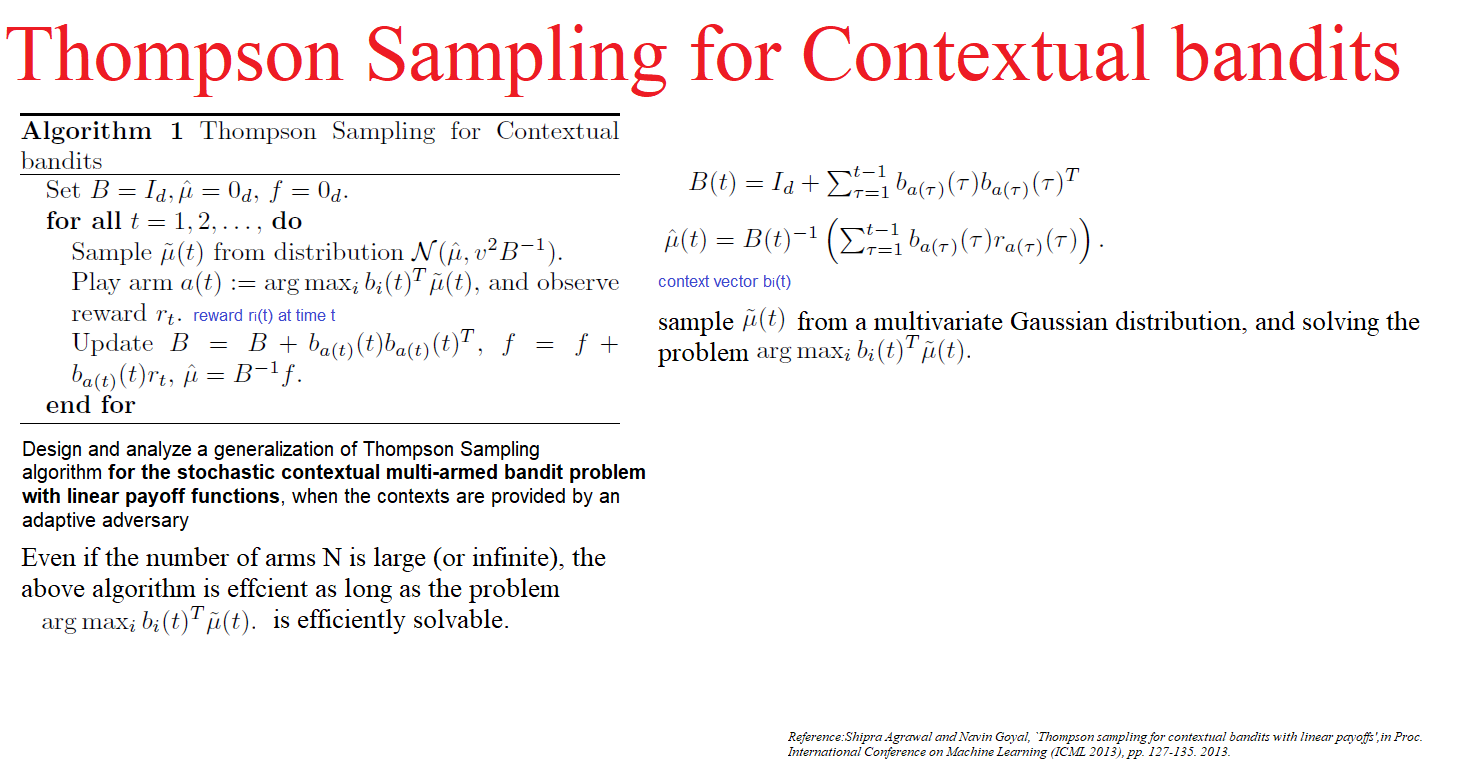

In [24]:
Image(filename="Thompson_context1.PNG",width=800,height=500)

In [25]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        self.narms=narms
        self.ndims=ndims
        self.v = v
        self.nrounds=0
        self.B = np.identity(self.ndims) #initial identity B matrix (common share parameter)
        self.u=np.zeros(self.ndims) #initial u vector (common share parameter)
        self.f = np.zeros(self.ndims)#initial f vector(common share parameter)

        
    def play(self, tround, context):
        
        if (tround <= self.nrounds) and (tround > 1):
            return None
        if tround == 0 or (tround > self.nrounds+1): #Invalid tround value 
            return None
        
        
        #generate sample u at each t from the Gaussian  distribution
        ut_samples = np.random.multivariate_normal(mean=self.u, cov=(self.v)**2*np.linalg.inv(self.B))
   
        a_t = np.empty(self.narms) #initiate expected payoff for each arm

        
        for i in range(self.narms):
            
            #get feature of arm i into shape (10,1)
            b_feature= np.array(context[i*self.ndims:(i+1)*self.ndims])#.reshape(-1,1) 
            
            b_feature_T = np.transpose(b_feature)
            
            #compute the expected payoff of arm i
            a_t[i] = np.dot(b_feature_T, ut_samples)
            
        max_arm = [i for i in range(self.narms) if a_t[i] == max(a_t)]#choose the arms with max payoff 
        chosen_arm = np.random.choice(max_arm)+1 #randomly choose a arm from max_arm list
        
        return chosen_arm

    def update(self, arm, reward, context):
        
        #update input arm's feature    
        b_feature = np.array(context[(arm-1)*self.ndims:(arm)*self.ndims])#.reshape(-1,1) 
        b_feature_T = np.transpose(b_feature.reshape(-1,1))
        
        #update share parameter
        self.B = self.B+np.dot(b_feature.reshape(-1,1),b_feature_T) #update B matrix

        self.f = self.f+reward * b_feature #update feature 

        self.u =np.dot(inv(self.B),self.f) #update u

        self.nrounds+=1
        
    

In [26]:
mab = LinThompson(10, 10, 1)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.31375


In [27]:
len(results_LinThompson)

800

## 6. Evaluation
### 6.A.

Run offline Evaluate on each of classes and plot the running per-round cumulative reward

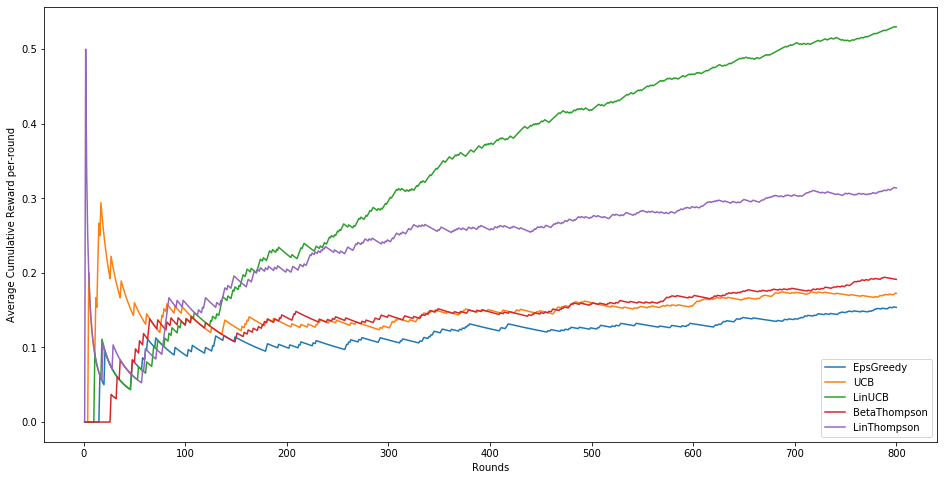

In [32]:
plt.figure(figsize=(16,8))
for mab in ['EpsGreedy', 'UCB', 'LinUCB','BetaThompson',"LinThompson"]:
    results = eval('results_'+ mab)
    tround = np.array(range(1, len(results) + 1))
    plt.plot(tround,np.cumsum(results)/tround,label=mab)


plt.xlabel("Rounds")
plt.ylabel("Average Cumulative Reward per-round")
plt.legend()
plt.show()

### 6.B.

how to optimise hyperparameters? Devise grid-search based strategies to select the α and v hyperparameters in LinUCB and LinThompson. Output the result of this strategy.

21:55:42.140646
03:44:30.275658
04:34:38.180848
This Best alpha of LinUCB is : 0.02002002002002002 , with maximum average reward: 0.73125 
This Best v of LinThompson is : 0.01001001001001001 , with maximum average reward: 0.4725 


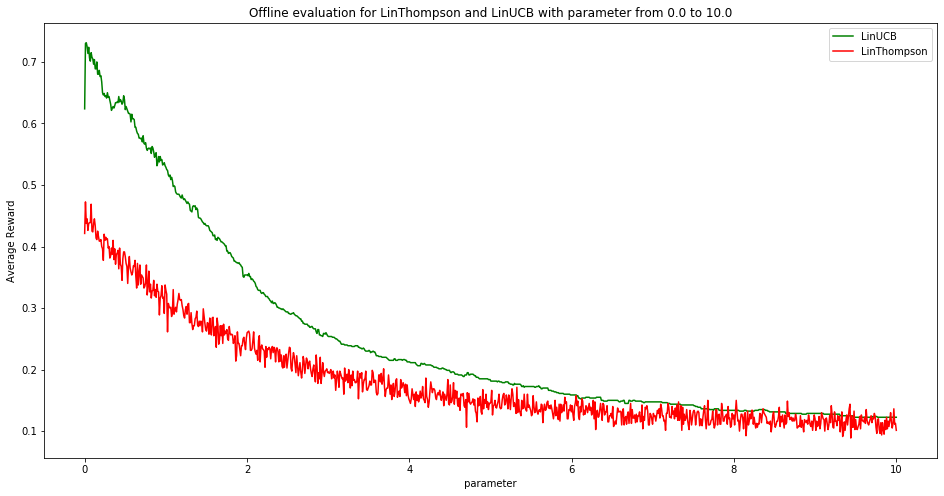

In [21]:
from datetime import datetime

t = datetime.time(datetime.now())
print(t)

#build greedy_search with avg_rewards dictionary as {key=parameter:value=average reward}
def greedy_search(start, top, num_step,mab):
    
    avg_rewards={}

    for parameter in np.linspace(start, top, num_step):        
        avg_rewards[parameter]=np.mean(offlineEvaluate(mab(10, 10, parameter), arms, rewards, contexts, 800))
    max_parameter=max(avg_rewards , key=avg_rewards.get)
    
    return max_parameter,avg_rewards

#alpha and v are all positive numbers so from 0 to 10

LinUCB_max_parameter,LinUCB_avg_rewards=greedy_search(0,10,1000,LinUCB)
t = datetime.time(datetime.now())
print(t)
#print(LinUCB_max_parameter,LinUCB_avg_rewards)
LinThompson_max_parameter,LinThompson_avg_rewards=greedy_search(0,10,1000,LinThompson)
t = datetime.time(datetime.now())
print(t)
#print(LinThompson_max_parameter,LinThompson_avg_rewards)


str = "This Best {} of {} is : {} , with maximum average reward: {} "
print (str.format("alpha","LinUCB",LinUCB_max_parameter,LinUCB_avg_rewards[LinUCB_max_parameter])) 
print (str.format("v","LinThompson",LinThompson_max_parameter,LinThompson_avg_rewards[LinThompson_max_parameter])) 

plt.figure(figsize=(16,8))

plt.plot(list(LinUCB_avg_rewards.keys()),list(LinUCB_avg_rewards.values()), color="green",label="LinUCB")
plt.plot(list(LinThompson_avg_rewards.keys()),list(LinThompson_avg_rewards.values()),color="red", label="LinThompson")


plt.title("Offline evaluation for LinThompson and LinUCB with parameter from 0.0 to 10.0")
plt.xlabel(" parameter ")
plt.ylabel( "Average Reward")
plt.legend()
plt.show()